In [1]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm


import os
import pickle

import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

X_train = pd.read_csv('Data/Data20260110/X_train_Final_10.csv', header=None, delimiter=',').values
X_test = pd.read_csv('LocalDisease/X_MI_1_5.csv', header=None, delimiter=',').values

Y_train_pca = pd.read_csv('Data/Data20260110/Y_data_train_pca.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('LocalDisease/Y_data_MI_1_pca.csv', header=None, delimiter=',').values




train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

train_y_21 = torch.tensor(Y_train_pca, dtype=torch.float32)
test_y_21 = torch.tensor(Y_test_21, dtype=torch.float32)



torch.set_default_dtype(torch.float32)

In [2]:
Device = 'cuda'


output_file = 'LocalDisease/Result/MVGP_MI_1_result.csv'

if not os.path.exists(output_file):
    with open(output_file, 'w') as f:
        f.write('Iteration,test_preds,estimated_params\n')

checkpoint = torch.load('multitask_gp_checkpoint_LocalD_tmp.pth', map_location=Device)
model_params = checkpoint['model_params']

MVGP_models = GP_models.MultitaskVariationalGP(train_x, train_y_21, 
                                               num_latents=model_params['num_latents'], 
                                               num_inducing=model_params['num_inducing'], 
                                               covar_type=model_params['covar_type']).to(Device)

MVGP_models.load_state_dict(checkpoint['model_state_dict'])

MVGP_likelihoods = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y_21.shape[1]).to(Device)
MVGP_likelihoods.load_state_dict(checkpoint['likelihood_state_dict'])

MVGP_models.eval()
MVGP_likelihoods.eval()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [3]:
row_idx = 0

In [4]:
input_point = test_y_21[row_idx, :]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_GPU(input_point, train_x, train_y_21, k=100)
bounds = bound.get_bounds(local_train_x)

In [5]:
mcmc_result_Uniform = Estimation.run_mcmc_Uniform_Optimized(
        Prediction.preds_distribution, MVGP_models, MVGP_likelihoods, 
        row_idx, test_y_21, bounds, 
        num_sampling=1200, warmup_step=300, num_chains=1, device=Device
    )

Sample: 100%|██████████| 1500/1500 [17:30,  1.43it/s, step size=8.14e-02, acc. prob=0.915]


In [6]:
posterior_samples_Uniform = mcmc_result_Uniform.get_samples()

In [7]:
posterior_samples = Tools.extract_vector_params_from_mcmc(
    posterior_samples_Uniform,
    key="params",
    param_names=[f"theta_{i}" for i in range(10)]  # 你也可以用真实参数名
)

Ca_1: R-hat = 1.013, split R-hat = 1.012, ESS = 260.8, true = 2.07


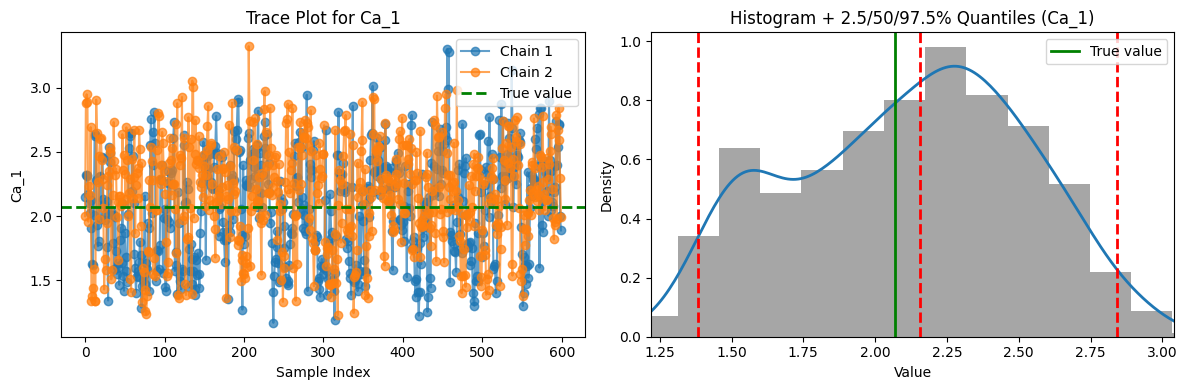

<Figure size 600x400 with 0 Axes>

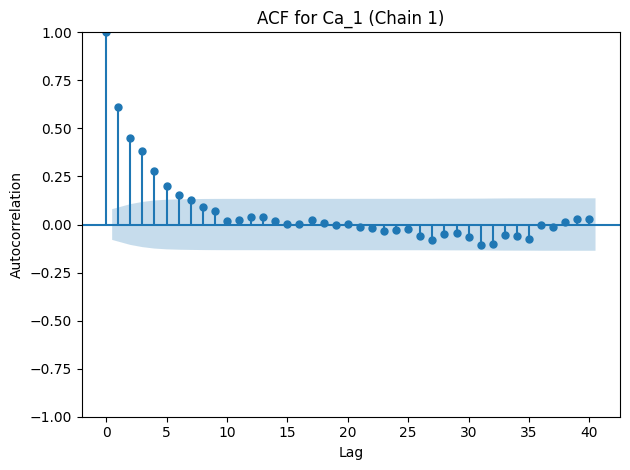

Cb_1: R-hat = 1.012, split R-hat = 1.009, ESS = 279.9, true = 2.3466


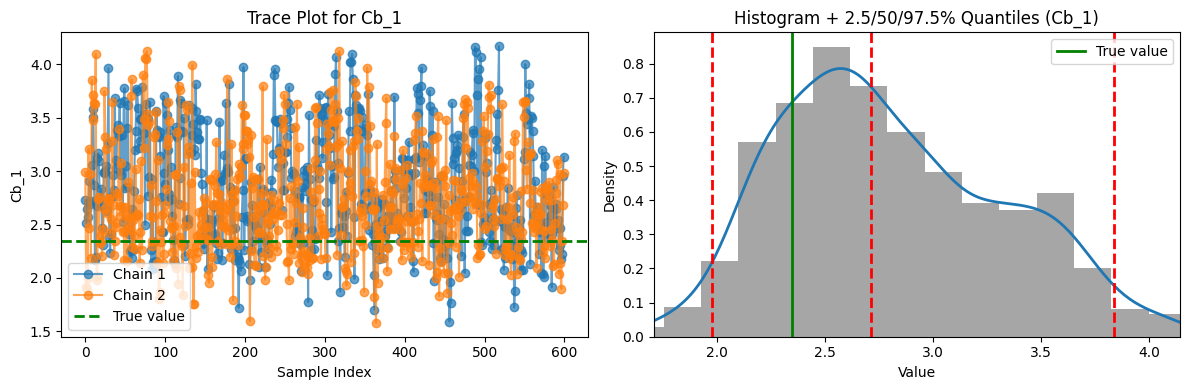

<Figure size 600x400 with 0 Axes>

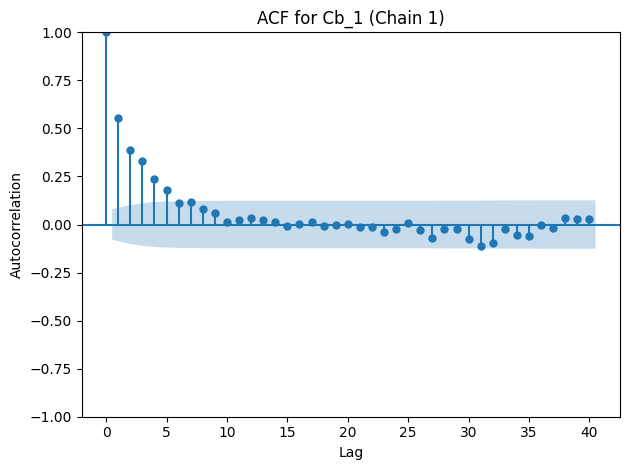

Ca_2: R-hat = 1.006, split R-hat = 1.009, ESS = 412.3, true = 1.1437


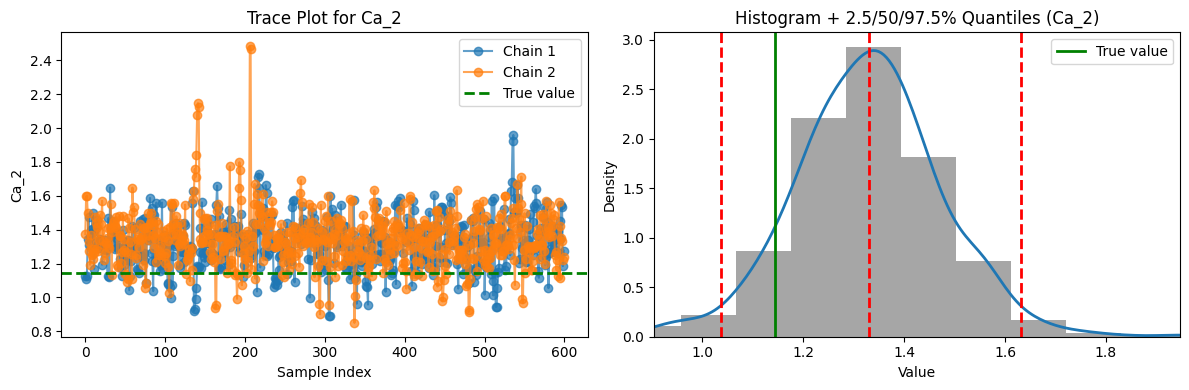

<Figure size 600x400 with 0 Axes>

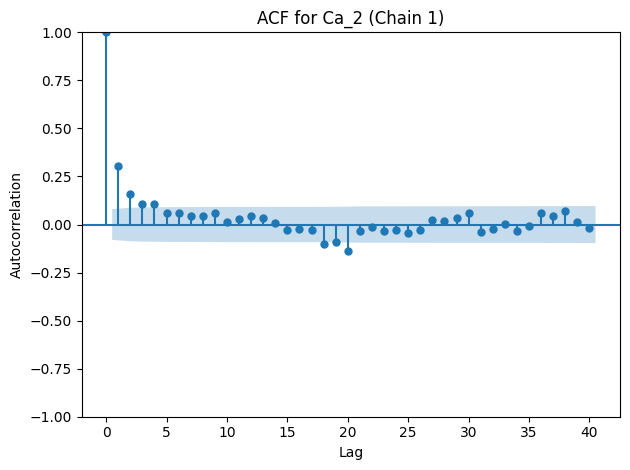

Cb_2: R-hat = 1.007, split R-hat = 1.007, ESS = 472.8, true = 1.1468


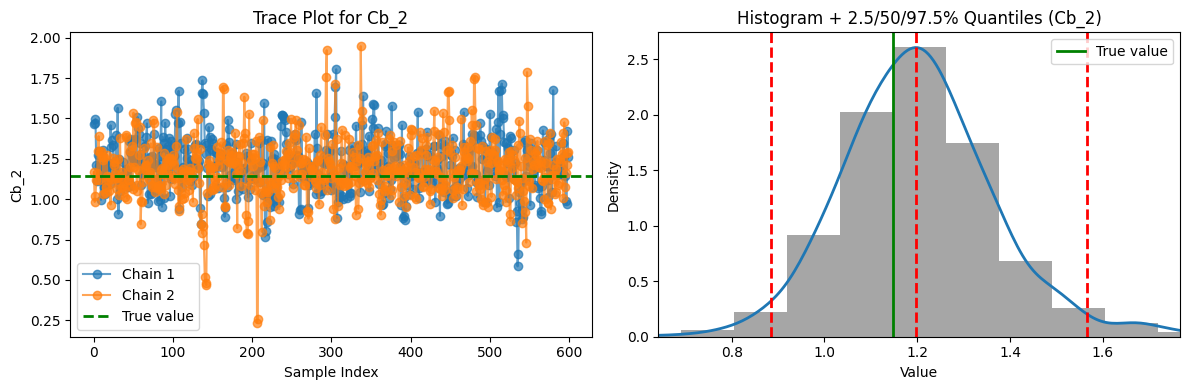

<Figure size 600x400 with 0 Axes>

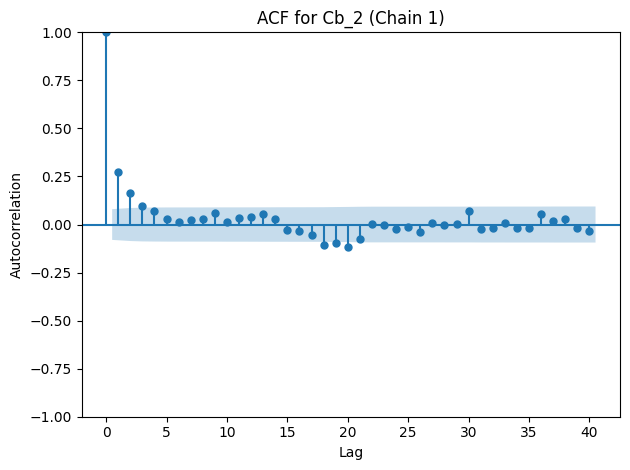

Ca_3: R-hat = 1.000, split R-hat = 1.004, ESS = 551.0, true = 1.1847


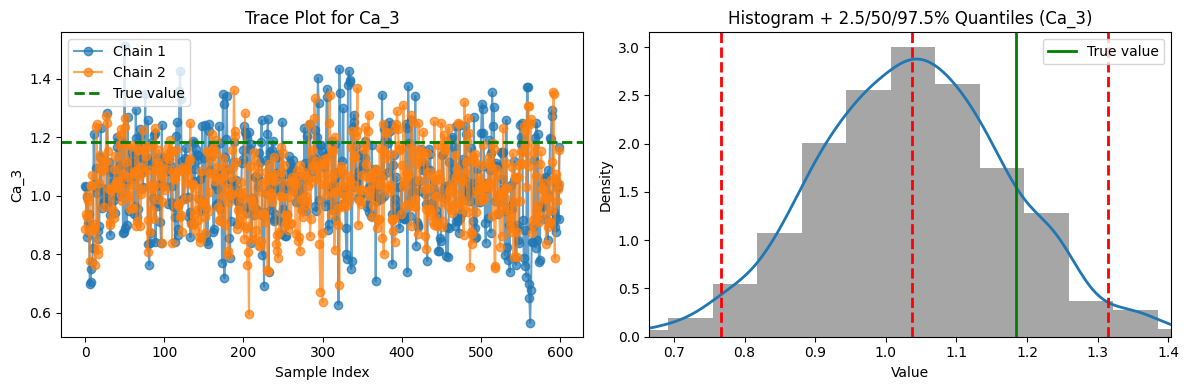

<Figure size 600x400 with 0 Axes>

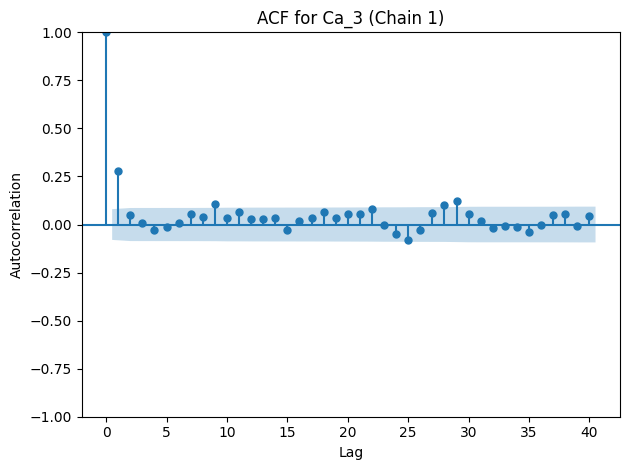

Cb_3: R-hat = 0.999, split R-hat = 1.003, ESS = 535.9, true = 1.1417


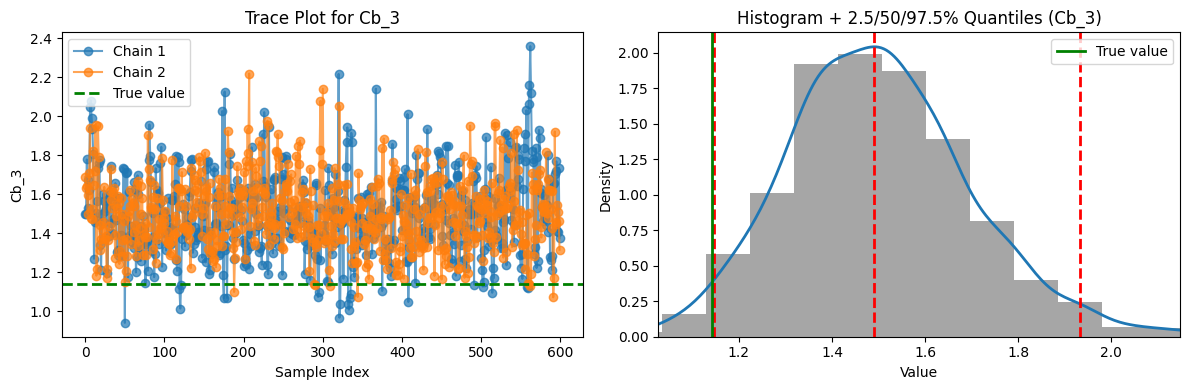

<Figure size 600x400 with 0 Axes>

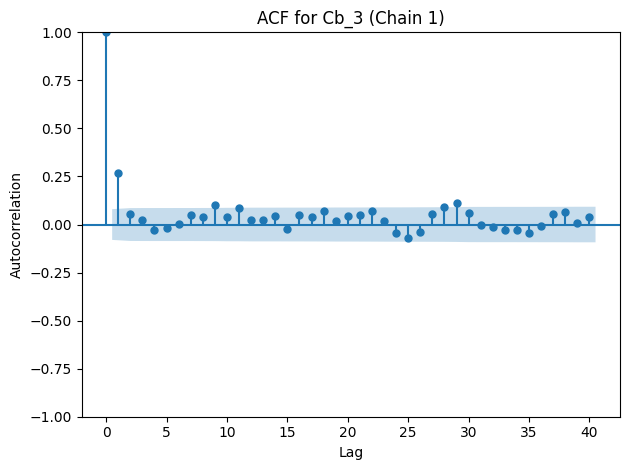

Ca_4: R-hat = 1.014, split R-hat = 1.012, ESS = 254.4, true = 1.1672


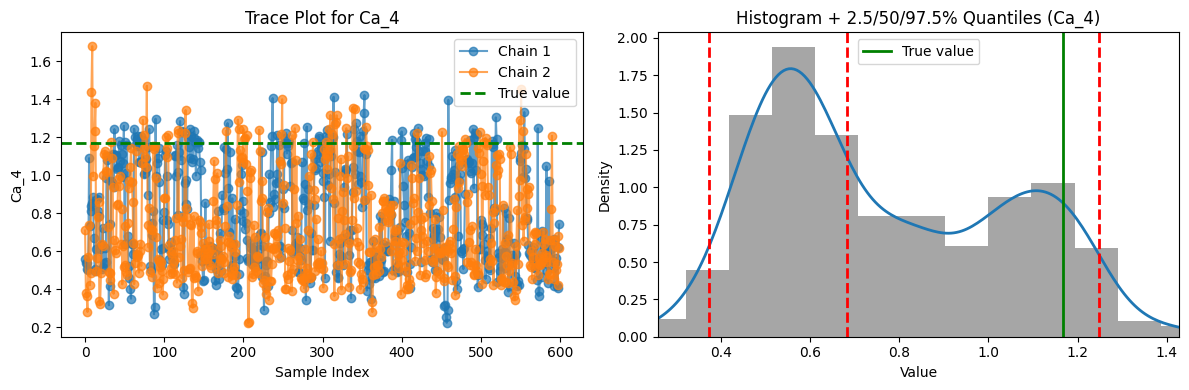

<Figure size 600x400 with 0 Axes>

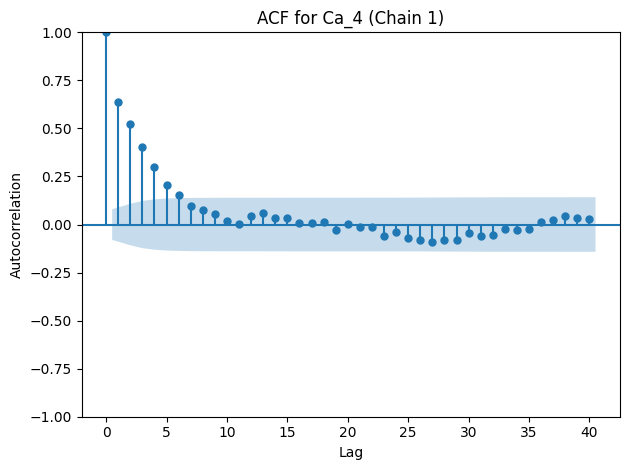

Cb_4: R-hat = 1.013, split R-hat = 1.011, ESS = 289.8, true = 1.2229


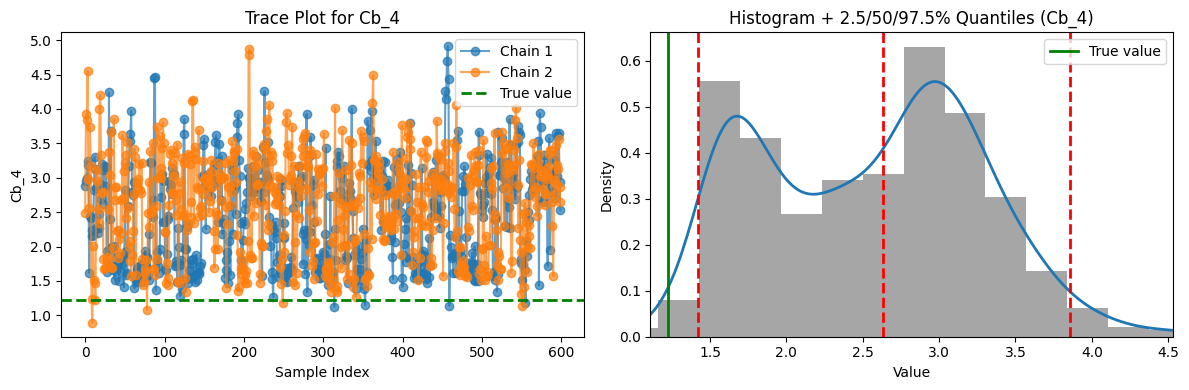

<Figure size 600x400 with 0 Axes>

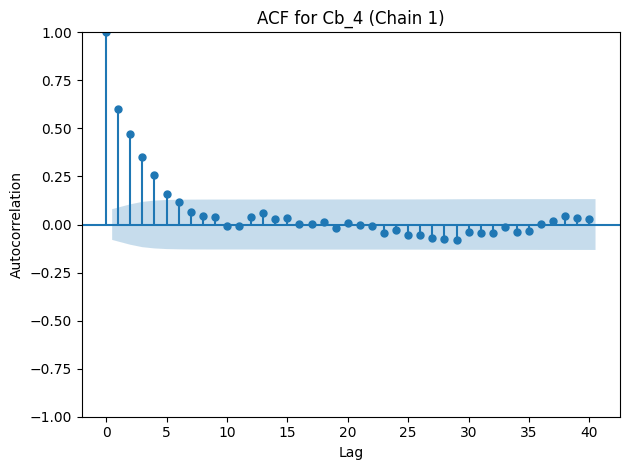

Ca_5: R-hat = 0.999, split R-hat = 0.999, ESS = 715.1, true = 1.1382


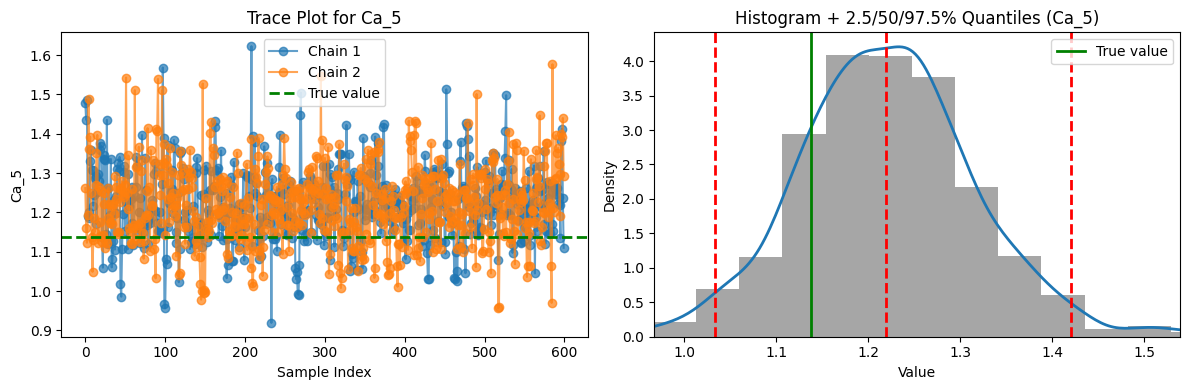

<Figure size 600x400 with 0 Axes>

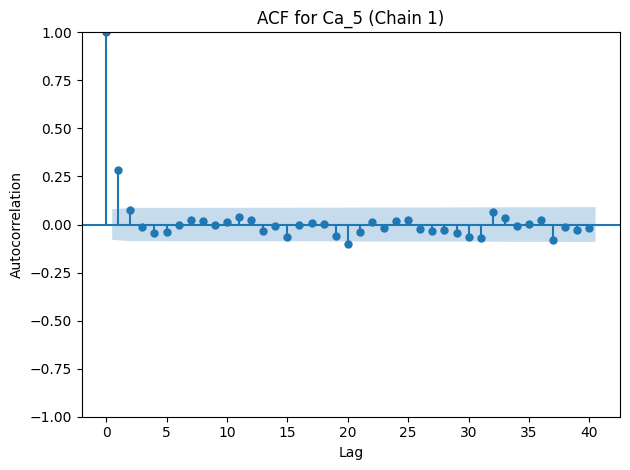

Cb_5: R-hat = 0.999, split R-hat = 0.999, ESS = 743.6, true = 1.142


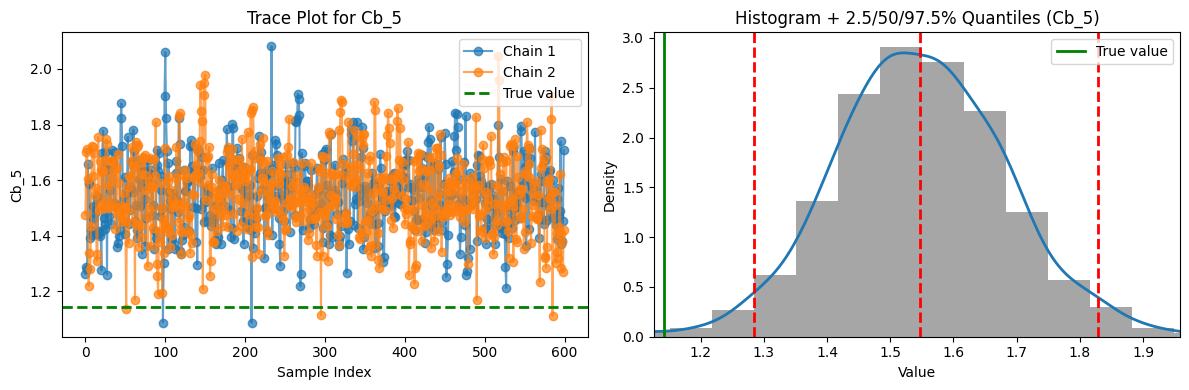

<Figure size 600x400 with 0 Axes>

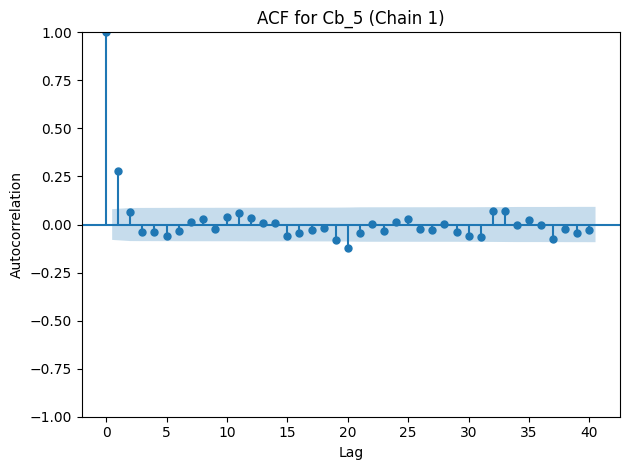

In [8]:
Tools.visualize_posterior_1d_params(
    posterior_samples,
    true_params_tensor=X_test[row_idx],
    # true_params_tensor=None,
    bins=15,
    acf_lags=40,
    clip_percentiles=(0.5, 99.5),
    xlim=None, 
)

In [9]:
posterior_samples

{'theta_0': tensor([2.1524, 2.3160, 2.3173,  ..., 2.5918, 2.2972, 1.9908], device='cuda:0'),
 'theta_1': tensor([2.7278, 2.5110, 2.6427,  ..., 2.3474, 2.6874, 2.9815], device='cuda:0'),
 'theta_2': tensor([1.1273, 1.1066, 1.1281,  ..., 1.3351, 1.2206, 1.2365], device='cuda:0'),
 'theta_3': tensor([1.4667, 1.4722, 1.4954,  ..., 1.2128, 1.2882, 1.2954], device='cuda:0'),
 'theta_4': tensor([1.0330, 1.0291, 0.8607,  ..., 1.0232, 1.0407, 1.1558], device='cuda:0'),
 'theta_5': tensor([1.4995, 1.4988, 1.7784,  ..., 1.5107, 1.4650, 1.3159], device='cuda:0'),
 'theta_6': tensor([0.5613, 0.5382, 0.5377,  ..., 0.4241, 0.6814, 0.6144], device='cuda:0'),
 'theta_7': tensor([2.8868, 2.9491, 2.9992,  ..., 3.5625, 2.6457, 2.8729], device='cuda:0'),
 'theta_8': tensor([1.4781, 1.4355, 1.4860,  ..., 1.3926, 1.4400, 1.2920], device='cuda:0'),
 'theta_9': tensor([1.2624, 1.2874, 1.2813,  ..., 1.3756, 1.2675, 1.4200], device='cuda:0')}

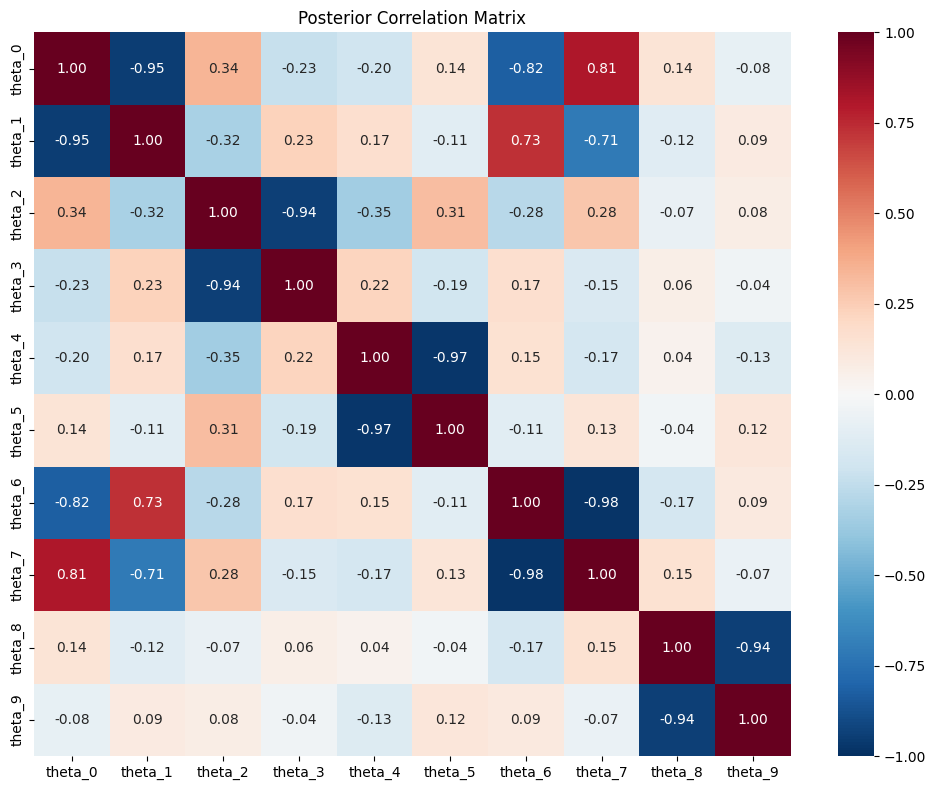

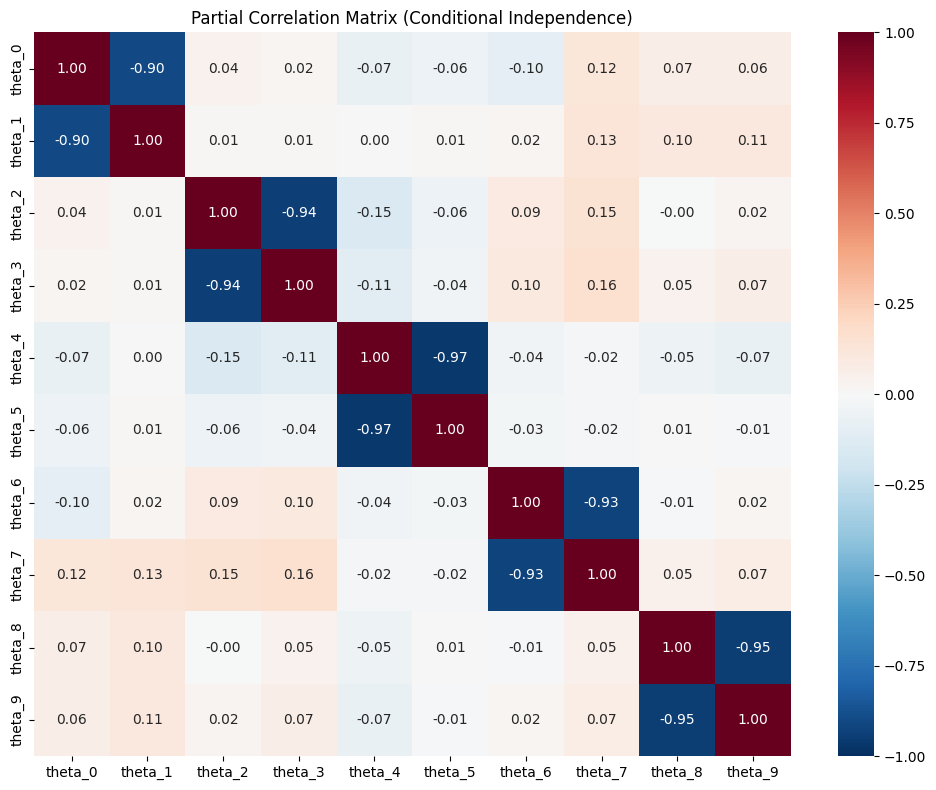

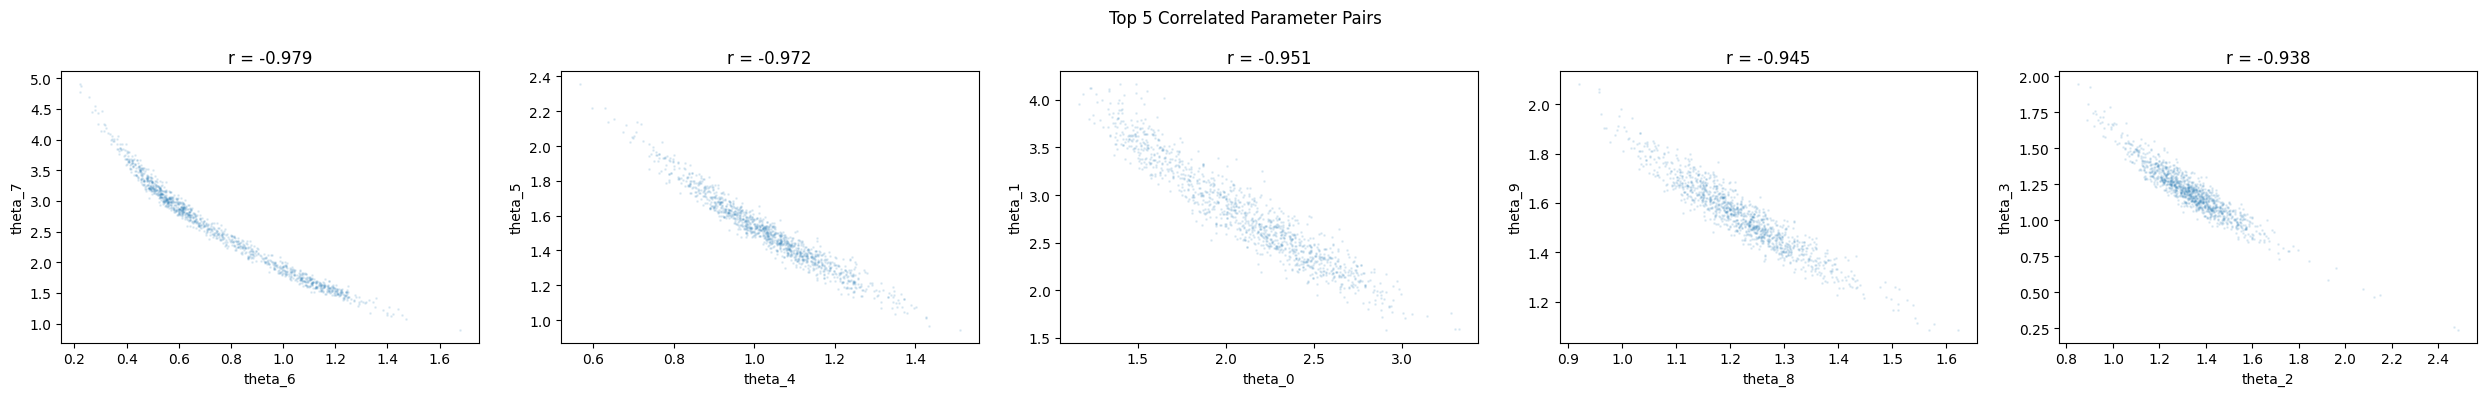

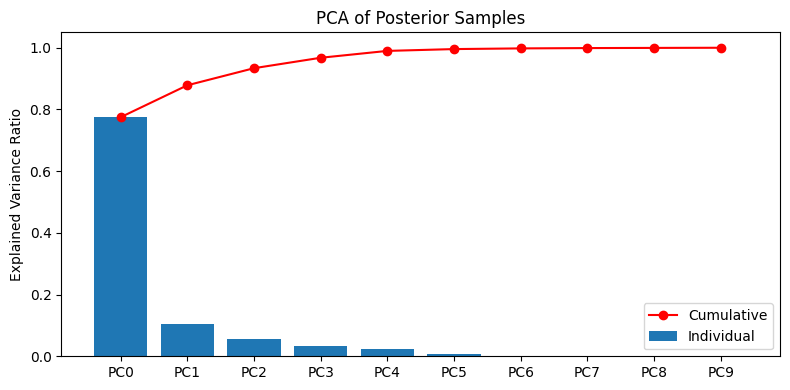

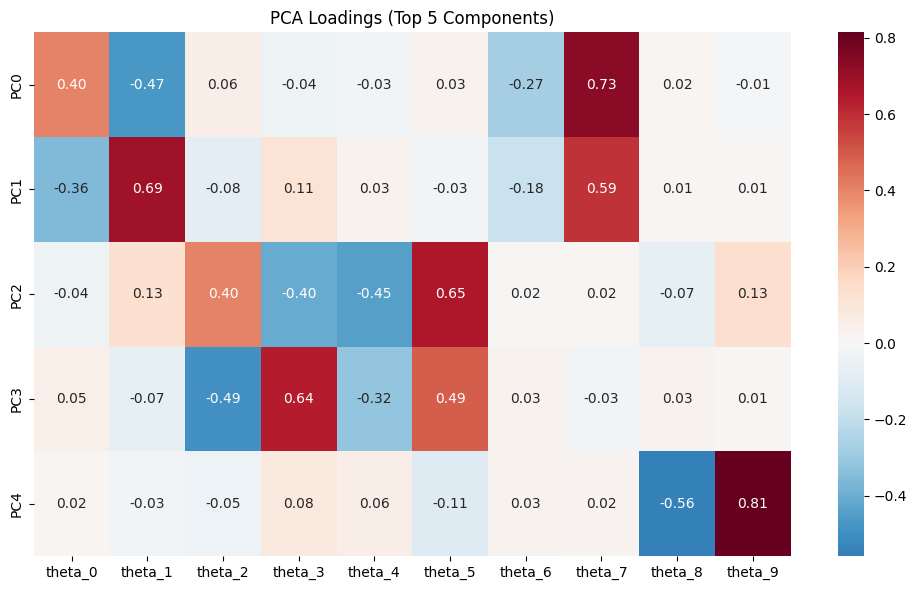

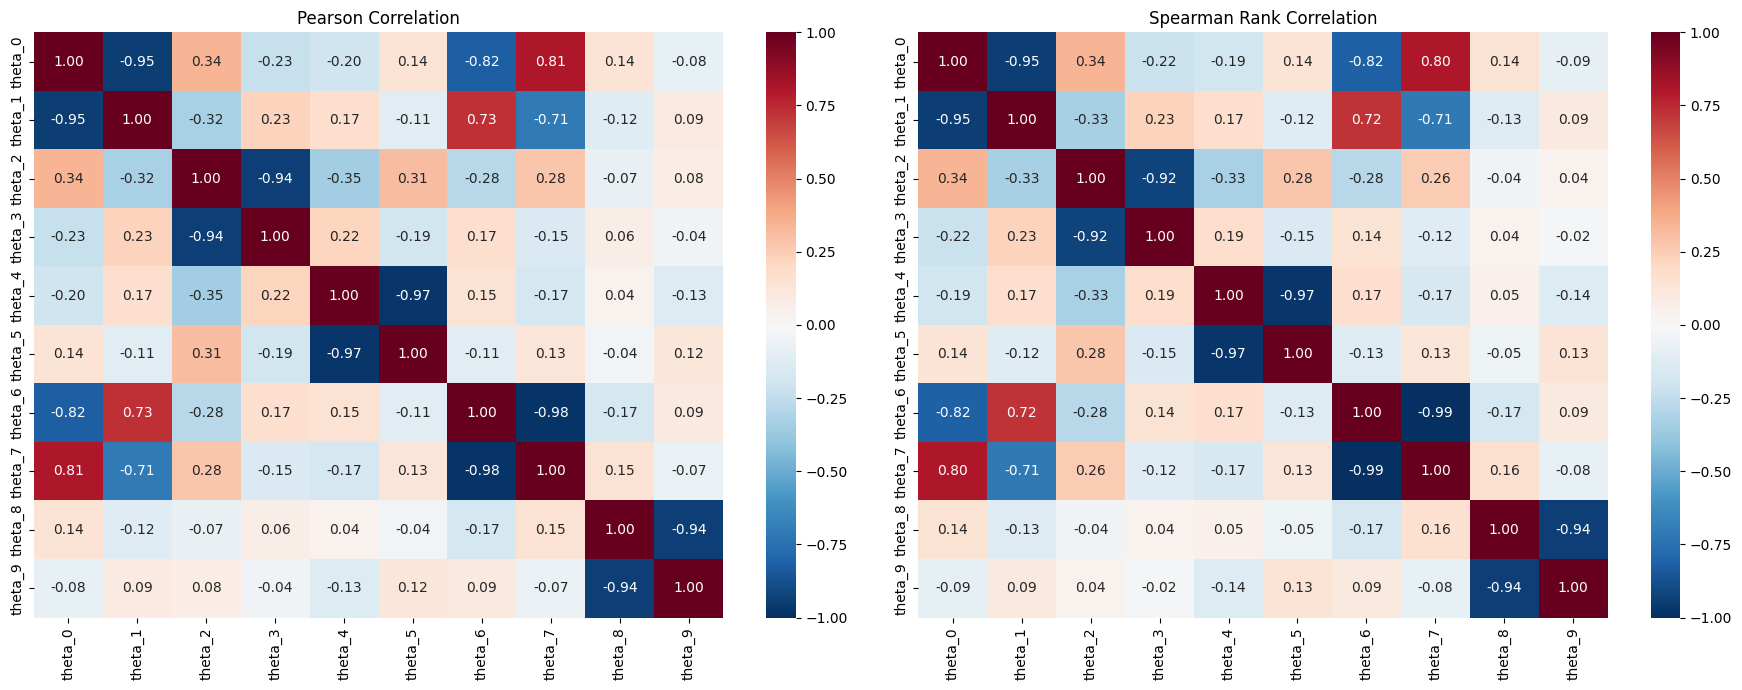

后验相关结构分析摘要

样本数: 1200, 参数数: 10

--- 强相关参数对 (|r| > 0.5) ---
  theta_6 <-> theta_7: r = -0.979
  theta_4 <-> theta_5: r = -0.972
  theta_0 <-> theta_1: r = -0.951
  theta_8 <-> theta_9: r = -0.945
  theta_2 <-> theta_3: r = -0.938
  theta_0 <-> theta_6: r = -0.824
  theta_0 <-> theta_7: r = +0.810
  theta_1 <-> theta_6: r = +0.732
  theta_1 <-> theta_7: r = -0.710

--- PCA 累计方差 ---
  前1个主成分解释方差: 77.5%
  前3个主成分解释方差: 93.4%
  前5个主成分解释方差: 99.0%

--- Pearson vs Spearman 差异大的参数对 (可能存在非线性) ---


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ============ 1. 数据准备 ============
# 假设 samples_dict 就是你的采样结果
param_names = [f'theta_{i}' for i in range(10)]
# 转为 numpy，堆叠成 (N_samples, 10) 矩阵
samples = np.column_stack([posterior_samples[k].cpu().numpy() for k in param_names])

# ============ 2. 后验相关矩阵热力图 ============
corr = np.corrcoef(samples, rowvar=False)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f",
            xticklabels=param_names, yticklabels=param_names,
            cmap="RdBu_r", vmin=-1, vmax=1, center=0, ax=ax)
ax.set_title("Posterior Correlation Matrix")
plt.tight_layout()
# plt.savefig("correlation_matrix.png", dpi=150)
plt.show()

# ============ 3. 精度矩阵（条件独立结构） ============
cov = np.cov(samples, rowvar=False)
precision = np.linalg.inv(cov)
# 标准化为偏相关矩阵
D = np.diag(1.0 / np.sqrt(np.diag(precision)))
partial_corr = -D @ precision @ D
np.fill_diagonal(partial_corr, 1.0)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(partial_corr, annot=True, fmt=".2f",
            xticklabels=param_names, yticklabels=param_names,
            cmap="RdBu_r", vmin=-1, vmax=1, center=0, ax=ax)
ax.set_title("Partial Correlation Matrix (Conditional Independence)")
plt.tight_layout()
# plt.savefig("partial_correlation.png", dpi=150)
plt.show()

# ============ 4. 成对散点图（重点关注高相关参数对） ============
# 找出相关性最强的前5对
import itertools
pairs = []
for i, j in itertools.combinations(range(10), 2):
    pairs.append((i, j, abs(corr[i, j])))
pairs.sort(key=lambda x: x[2], reverse=True)

fig, axes = plt.subplots(1, 5, figsize=(25, 4))
for idx, (i, j, r) in enumerate(pairs[:5]):
    axes[idx].scatter(samples[:, i], samples[:, j], alpha=0.1, s=1)
    axes[idx].set_xlabel(param_names[i])
    axes[idx].set_ylabel(param_names[j])
    axes[idx].set_title(f"r = {corr[i,j]:.3f}")
plt.suptitle("Top 5 Correlated Parameter Pairs")
plt.tight_layout()
# plt.savefig("top_pairs.png", dpi=150)
plt.show()

# ============ 5. PCA 分析 ============
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(samples)
explained = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(10), explained, label="Individual")
ax.plot(range(10), np.cumsum(explained), 'r-o', label="Cumulative")
ax.set_xticks(range(10))
ax.set_xticklabels([f"PC{i}" for i in range(10)])
ax.set_ylabel("Explained Variance Ratio")
ax.set_title("PCA of Posterior Samples")
ax.legend()
plt.tight_layout()
# plt.savefig("pca.png", dpi=150)
plt.show()

# 主成分载荷
loadings = pca.components_  # (10, 10)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(loadings[:5], annot=True, fmt=".2f",
            xticklabels=param_names, yticklabels=[f"PC{i}" for i in range(5)],
            cmap="RdBu_r", center=0, ax=ax)
ax.set_title("PCA Loadings (Top 5 Components)")
plt.tight_layout()
# plt.savefig("pca_loadings.png", dpi=150)
plt.show()

# ============ 6. Spearman 秩相关（捕获非线性） ============
spearman_corr, _ = stats.spearmanr(samples)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", vmin=-1, vmax=1,
            xticklabels=param_names, yticklabels=param_names, ax=axes[0])
axes[0].set_title("Pearson Correlation")
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="RdBu_r", vmin=-1, vmax=1,
            xticklabels=param_names, yticklabels=param_names, ax=axes[1])
axes[1].set_title("Spearman Rank Correlation")
plt.tight_layout()
# plt.savefig("pearson_vs_spearman.png", dpi=150)
plt.show()

# ============ 7. 汇总报告 ============
print("="*60)
print("后验相关结构分析摘要")
print("="*60)
print(f"\n样本数: {samples.shape[0]}, 参数数: {samples.shape[1]}")
print(f"\n--- 强相关参数对 (|r| > 0.5) ---")
for i, j, r in pairs:
    if r > 0.5:
        print(f"  {param_names[i]} <-> {param_names[j]}: r = {corr[i,j]:+.3f}")

print(f"\n--- PCA 累计方差 ---")
for k in [1, 3, 5]:
    print(f"  前{k}个主成分解释方差: {np.cumsum(explained)[k-1]*100:.1f}%")

print(f"\n--- Pearson vs Spearman 差异大的参数对 (可能存在非线性) ---")
for i, j in itertools.combinations(range(10), 2):
    diff = abs(corr[i,j] - spearman_corr[i,j])
    if diff > 0.05:
        print(f"  {param_names[i]} <-> {param_names[j]}: "
              f"Pearson={corr[i,j]:+.3f}, Spearman={spearman_corr[i,j]:+.3f}, Δ={diff:.3f}")